In [1]:
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from PIL import Image
import numpy as np
import sys

import torch
from torch import nn
from torch.autograd import Variable, Function
from torchvision import models, transforms
import torchvision.models as models

%matplotlib inline

print("mpl backend: ", plt.get_backend())

mpl backend:  module://ipykernel.pylab.backend_inline


In [2]:
torch.cuda.set_device(3)

In [3]:
vgg16_pretrained = models.vgg16(pretrained=True).eval().cuda()

class VGG16_conv(torch.nn.Module):
    def __init__(self, n_classes):
        super(VGG16_conv, self).__init__()
        # VGG16 (using return_indices=True on the MaxPool2d layers)
        self.features = torch.nn.Sequential(
            # conv1
            torch.nn.Conv2d(3, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv2
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv3
            torch.nn.Conv2d(128, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv4
            torch.nn.Conv2d(256, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv5
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True))
        self.feature_outputs = [0]*len(self.features)
        self.pool_indices = dict()

        self.classifier = vgg16_pretrained.classifier
        self._initialize_weights()


    def _initialize_weights(self):
        # initializing weights using ImageNet-trained model from PyTorch
        for i, layer in enumerate(vgg16_pretrained.features):
            print("initializing layer {}: {}".format(i, layer))
            try:
                self.features[i].weight.data = layer.weight.data
                self.features[i].bias.data = layer.bias.data
            except:
                continue

    def get_conv_layer_indices(self):
        return [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]

    def forward_features(self, x):
        output = x
        for i, layer in enumerate(self.features):
            if isinstance(layer, torch.nn.MaxPool2d):
                output, indices = layer(output)
                self.feature_outputs[i] = output
                self.pool_indices[i] = indices
            else:
                output = layer(output)
                self.feature_outputs[i] = output
        return output

    def forward(self, x):
        x = self.forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [4]:
class VGG16_deconv(torch.nn.Module):
    def __init__(self):
        super(VGG16_deconv, self).__init__()
        self.conv2DeconvIdx = {0:17, 2:16, 5:14, 7:13, 10:11, 12:10, 14:9, 17:7, 19:6, 21:5, 24:3, 26:2, 28:1}
        self.conv2DeconvBiasIdx = {0:16, 2:14, 5:13, 7:11, 10:10, 12:9, 14:7, 17:6, 19:5, 21:3, 24:2, 26:1, 28:0}
        self.unpool2PoolIdx = {15:4, 12:9, 8:16, 4:23, 0:30}
        
        self.deconv_features = torch.nn.Sequential(
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 256, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(256, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(256, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(256, 128, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(128, 128, 3, padding=1),
            torch.nn.ConvTranspose2d(128, 64, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(64, 64, 3, padding=1),
            torch.nn.ConvTranspose2d(64, 3, 3, padding=1))

        # not the most elegant, given that I don't need the MaxUnpools here
        self.deconv_first_layers = torch.nn.ModuleList([
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 256, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 128, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 128, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 64, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 64, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 3, 3, padding=1) ])

        self._initialize_weights()

    def _initialize_weights(self):
        # initializing weights using ImageNet-trained model from PyTorch
        for i, layer in enumerate(vgg16_pretrained.features):
            if isinstance(layer, torch.nn.Conv2d):
                self.deconv_features[self.conv2DeconvIdx[i]].weight.data = layer.weight.data
                biasIdx = self.conv2DeconvBiasIdx[i]
                if biasIdx > 0:
                    self.deconv_features[biasIdx].bias.data = layer.bias.data
                

    def forward(self, x, layer_number, map_number, pool_indices):
        start_idx = self.conv2DeconvIdx[layer_number]
        if not isinstance(self.deconv_first_layers[start_idx], torch.nn.ConvTranspose2d):
            raise ValueError('Layer '+str(layer_number)+' is not of type Conv2d')
        # set weight and bias
        self.deconv_first_layers[start_idx].weight.data = self.deconv_features[start_idx].weight[map_number].data[None, :, :, :]
        self.deconv_first_layers[start_idx].bias.data = self.deconv_features[start_idx].bias.data        
        # first layer will be single channeled, since we're picking a particular filter
        output = self.deconv_first_layers[start_idx](x)

        # transpose conv through the rest of the network
        for i in range(start_idx+1, len(self.deconv_features)):
            if isinstance(self.deconv_features[i], torch.nn.MaxUnpool2d):
                output = self.deconv_features[i](output, pool_indices[self.unpool2PoolIdx[i]])
            else:
                output = self.deconv_features[i](output)
        return output

In [5]:
from math import sqrt, ceil

def vis_layer(activ_map, sh):
    plt.clf()
    plt.subplot(121)
    h = np.int(np.sqrt(sh[1]))
    plt.xticks([i*sh[3]+i+sh[3]/2 for i in range(h)], [i for i in range(h)])
    plt.yticks([i*sh[2]+i+sh[2]/2 for i in range(h)], [i for i in range(h)])
    plt.grid(False)
    plt.imshow(activ_map[:,:,0], cmap='gray')

def decon_img(layer_output):
    if isinstance(layer_output, np.ndarray):
        raw_img = layer_output[0].transpose(1,2,0)
    else:
        if isinstance(layer_output, torch.autograd.Variable):
            raw_img = layer_output.data.cpu().numpy()[0].transpose(1,2,0)
        else:
            raw_img = layer_output.cpu().numpy()[0].transpose(1,2,0)
    img = (raw_img-raw_img.min())/(raw_img.max()-raw_img.min())*255
    img = img.astype(np.uint8)
    return img


def vis_grid(Xs, im=0):
    """ visualize a grid of images """
    (N, C, H, W) = Xs.shape
    A = int(ceil(sqrt(C)))
    G = np.ones((A*H+A, A*W+A, 1), Xs.dtype)
    G *= np.min(Xs)
    n = 0
    for y in range(A):
        for x in range(A):
            if n < C:
                G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, 0] = Xs[im, n,:,:]
                n += 1
    # normalize to [0,1]
    maxg = G.max()
    ming = G.min()
    G = (G - ming)/(maxg-ming)
    return G
  

In [6]:
n_classes = 1000 # using ImageNet pretrained weights

vgg16_c = VGG16_conv(n_classes).cuda()
conv_layer_indices = vgg16_c.get_conv_layer_indices()
print('VGG16 model:')
print(vgg16_c)

tmp = "".join(open("../labels.txt", 'r').readlines()).replace("\n", "")
labeldict = eval(tmp)

initializing layer 0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 1: ReLU (inplace)
initializing layer 2: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 3: ReLU (inplace)
initializing layer 4: MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
initializing layer 5: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 6: ReLU (inplace)
initializing layer 7: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 8: ReLU (inplace)
initializing layer 9: MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
initializing layer 10: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 11: ReLU (inplace)
initializing layer 12: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 13: ReLU (inplace)
initializing layer 14: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
tr_feed = transforms.Compose([
          transforms.Scale(224),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          normalize,
          ])

tr_debug = transforms.Compose([
           transforms.Scale(224),
           transforms.CenterCrop(224),
           np.asarray
           ])

In [8]:
import re
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader

In [59]:
class ImagenetDataset(Dataset):
    def __init__(self, filespath, labelspath, transform=None):
        super(Dataset, self).__init__()
        
        self.transform = transform
        self.filespath = filespath
        self.labelspath = labelspath
        
        self.regexp = re.compile("(n[0-9]+)")
        self.files = OrderedDict()

        with open(filespath, 'r') as f, open(labelspath, 'r') as g:
            self.labels = {i[0]:(int(i[1]), i[2]) for i in [i.split() for i in g.readlines()]}
            self.labeldict = {v[0]:v[1] for k, v in self.labels.items()}
            for i in f.read().splitlines():
                 self.files[i] = self.regexp.search(i).group(1)
        
        self.keys = list(self.files.keys())
        self.files = OrderedDict((k, self.files[k]) for k in self.keys)
                
    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        imname = self.keys[idx]
        print(imname)
        wordnet_class = self.files[imname]
        num_class = self.labels[wordnet_class][0]
        human_class = self.labels[wordnet_class][1]
        
        f = open(imname, 'rb')
        img = Image.open(f)
        if self.transform:
            img = self.transform(img)

        return img, num_class, wordnet_class, human_class

In [60]:
filespath = "/home/lestsovba/dataset/imagenet/ImageNet_Utils/files.txt"
labelspath = "/home/lestsovba/dataset/imagenet/valid_labels.txt"

data = ImagenetDataset(filespath, labelspath, tr_feed)
batchsize = 1
dataloader = DataLoader(data, batch_size=batchsize,
                        shuffle=False, num_workers=1)

In [66]:
path = "/home/lestsovba/dataset/imagenet/ImageNet_Utils/n02066245/n02066245_urlimages/451883386_eba67182d4.jpg"

f = open(path, 'rb')
raw_img = Image.open(f)
tr_img = tr_feed(raw_img)
datatensor = tr_img.unsqueeze(0)

img_var = Variable(datatensor.cuda(), requires_grad=False)
conv_out = vgg16_c.forward(img_var)
res = nn.Softmax()(conv_out)
prob, ind = torch.topk(res, 5)

for image in range(batchsize):
    print("Pic:", image)
    for i in range(ind.size()[1]):
        print(" "*4, labeldict[ind[image, i].data[0]], " : ", prob[image, i].data[0], " : ", ind[image, i].data[0])

Pic: 0
     eel  :  0.27563056349754333  :  390
     sturgeon  :  0.10545045137405396  :  394
     gar, garfish, garpike, billfish, Lepisosteus osseus  :  0.09503921866416931  :  395
     tiger shark, Galeocerdo cuvieri  :  0.06324158608913422  :  3
     sea cucumber, holothurian  :  0.052114635705947876  :  329


In [69]:
print(data.labeldict)

dict_items([('n02119789', (1, 'kit_fox')), ('n02100735', (2, 'English_setter')), ('n02110185', (3, 'Siberian_husky')), ('n02096294', (4, 'Australian_terrier')), ('n02102040', (5, 'English_springer')), ('n02066245', (6, 'grey_whale')), ('n02509815', (7, 'lesser_panda')), ('n02124075', (8, 'Egyptian_cat')), ('n02417914', (9, 'ibex')), ('n02123394', (10, 'Persian_cat')), ('n02125311', (11, 'cougar')), ('n02423022', (12, 'gazelle')), ('n02346627', (13, 'porcupine')), ('n02077923', (14, 'sea_lion')), ('n02110063', (15, 'malamute')), ('n02447366', (16, 'badger')), ('n02109047', (17, 'Great_Dane')), ('n02089867', (18, 'Walker_hound')), ('n02102177', (19, 'Welsh_springer_spaniel')), ('n02091134', (20, 'whippet')), ('n02092002', (21, 'Scottish_deerhound')), ('n02071294', (22, 'killer_whale')), ('n02442845', (23, 'mink')), ('n02504458', (24, 'African_elephant')), ('n02092339', (25, 'Weimaraner')), ('n02098105', (26, 'soft-coated_wheaten_terrier')), ('n02096437', (27, 'Dandie_Dinmont')), ('n02114

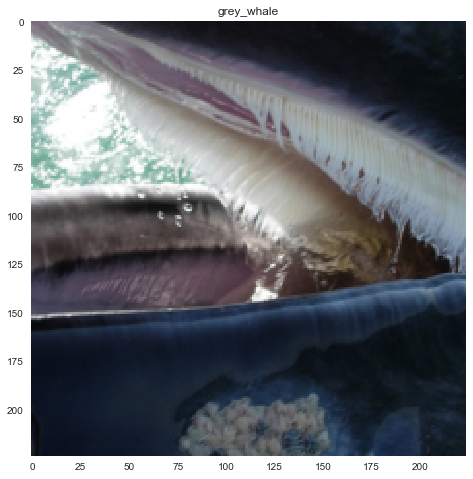

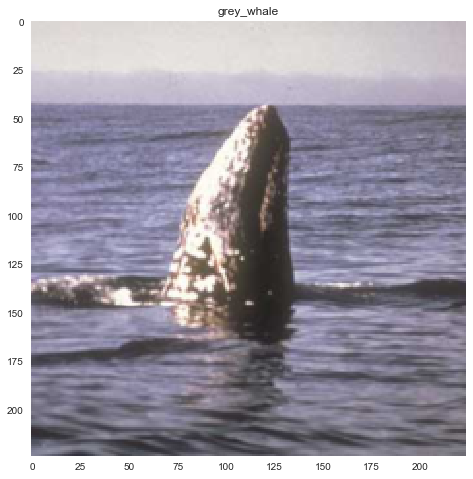

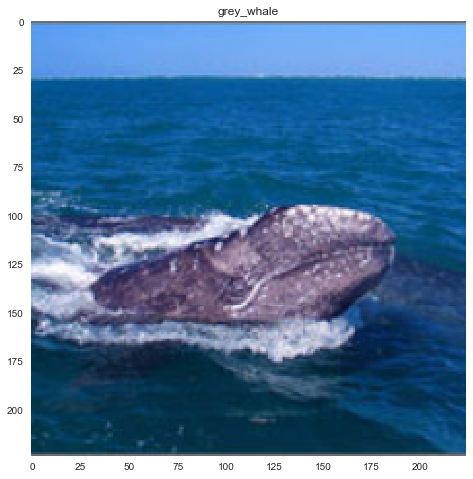

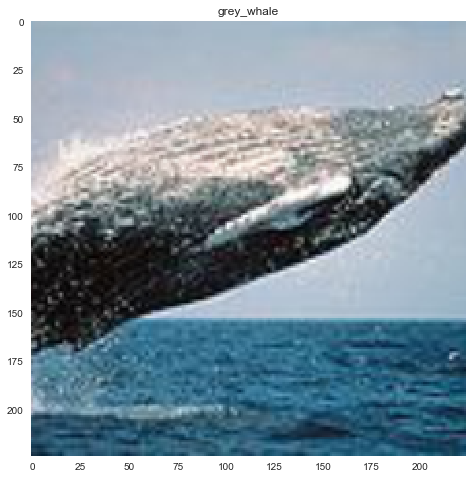

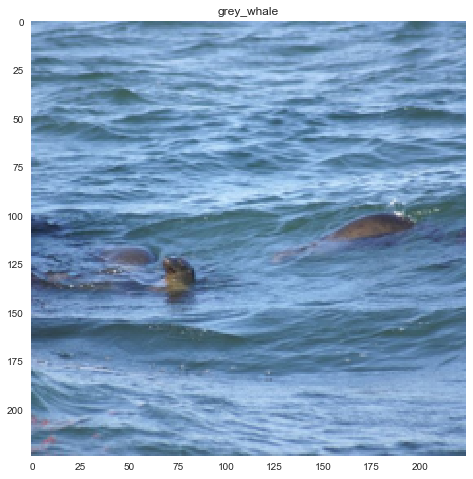

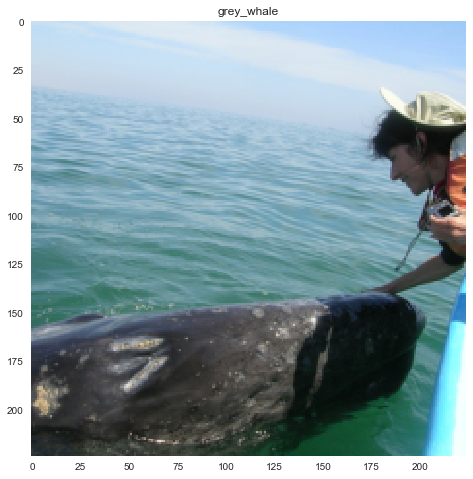

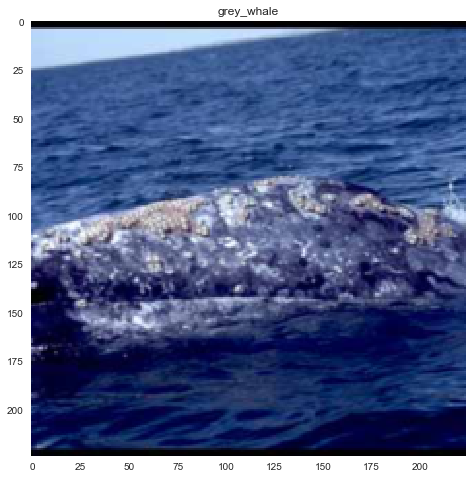

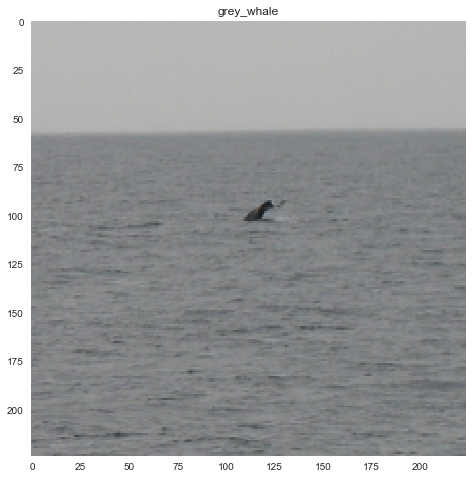

In [14]:
for i, batch in enumerate(dataloader):
    if i > 1:
        break
    for img, _, _, name in zip(*batch):
        plt.figure(figsize=(10,8))
        plt.title(name)
        plt.grid(False)
        plt.imshow(img.numpy())

In [207]:
for k, v in data.labeldict.items():
    print(k, v)

1 kit_fox
2 English_setter
3 Siberian_husky
4 Australian_terrier
5 English_springer
6 grey_whale
7 lesser_panda
8 Egyptian_cat
9 ibex
10 Persian_cat
11 cougar
12 gazelle
13 porcupine
14 sea_lion
15 malamute
16 badger
17 Great_Dane
18 Walker_hound
19 Welsh_springer_spaniel
20 whippet
21 Scottish_deerhound
22 killer_whale
23 mink
24 African_elephant
25 Weimaraner
26 soft-coated_wheaten_terrier
27 Dandie_Dinmont
28 red_wolf
29 Old_English_sheepdog
30 jaguar
31 otterhound
32 bloodhound
33 Airedale
34 hyena
35 meerkat
36 giant_schnauzer
37 titi
38 three-toed_sloth
39 sorrel
40 black-footed_ferret
41 dalmatian
42 black-and-tan_coonhound
43 papillon
44 skunk
45 Staffordshire_bullterrier
46 Mexican_hairless
47 Bouvier_des_Flandres
48 weasel
49 miniature_poodle
50 Cardigan
51 malinois
52 bighorn
53 fox_squirrel
54 colobus
55 tiger_cat
56 Lhasa
57 impala
58 coyote
59 Yorkshire_terrier
60 Newfoundland
61 brown_bear
62 red_fox
63 Norwegian_elkhound
64 Rottweiler
65 hartebeest
66 Saluki
67 grey_fox

In [65]:
sm = nn.Softmax()

for i, (img, _,_,_) in enumerate(data):
    if i > 1:
        break
    print("\nBatch {}:".format(i))
    datatensor = img.unsqueeze(0)
    print(datatensor)
    img_var = Variable(datatensor.cuda(), requires_grad=False)
    
    conv_out = vgg16_c.forward(img_var)
    res = sm(conv_out)
    prob, ind = torch.topk(res, 5)

    for image in range(batchsize):
        print("Pic:", image)
        for i in range(ind.size()[1]):
            print(" "*4, data.labeldict[ind[image, i].data[0]], " : ", prob[image, i].data[0], " : ", ind[image, i].data[0])

/home/lestsovba/dataset/imagenet/ImageNet_Utils/n02066245/n02066245_urlimages/451883386_eba67182d4.jpg

Batch 0:

( 0 , 0 ,.,.) = 
 -0.0287 -0.0629 -0.0801  ...  -1.7925 -1.7069 -1.6898
  0.0741 -0.0116 -0.0116  ...  -1.8439 -1.7412 -1.7754
  0.2967  0.1254  0.1083  ...  -1.8439 -1.8097 -1.7583
           ...             ⋱             ...          
 -1.5528 -1.6727 -1.9295  ...  -1.8439 -1.8610 -1.8953
 -1.5870 -1.6727 -1.9638  ...  -1.8268 -1.8610 -1.8782
 -1.6384 -1.6898 -1.9809  ...  -1.8439 -1.8097 -1.8097

( 0 , 1 ,.,.) = 
 -0.1099 -0.1275 -0.1800  ...  -1.5105 -1.4230 -1.3880
 -0.0049 -0.0924 -0.0924  ...  -1.5105 -1.4405 -1.4580
  0.2402  0.0826  0.0301  ...  -1.5630 -1.5280 -1.4755
           ...             ⋱             ...          
 -1.4580 -1.5630 -1.8081  ...  -1.5455 -1.5805 -1.5805
 -1.4930 -1.5805 -1.8431  ...  -1.5105 -1.5630 -1.5630
 -1.5455 -1.6155 -1.8782  ...  -1.5630 -1.5455 -1.4930

( 0 , 2 ,.,.) = 
  0.3219  0.3219  0.3219  ...  -1.1247 -0.9853 -0.9504
  0.4265

In [73]:
layer = 5
im = 3

(4, 128, 112, 112)
(2, 36, 83, 61)        2    0    21.94819450378418
(2, 48, 57, 109)       2    0    22.784873962402344
(2, 4, 47, 111)        2    0    23.011930465698242
(2, 89, 74, 102)       2    0    23.830724716186523
(2, 84, 37, 61)        2    0    24.123491287231445


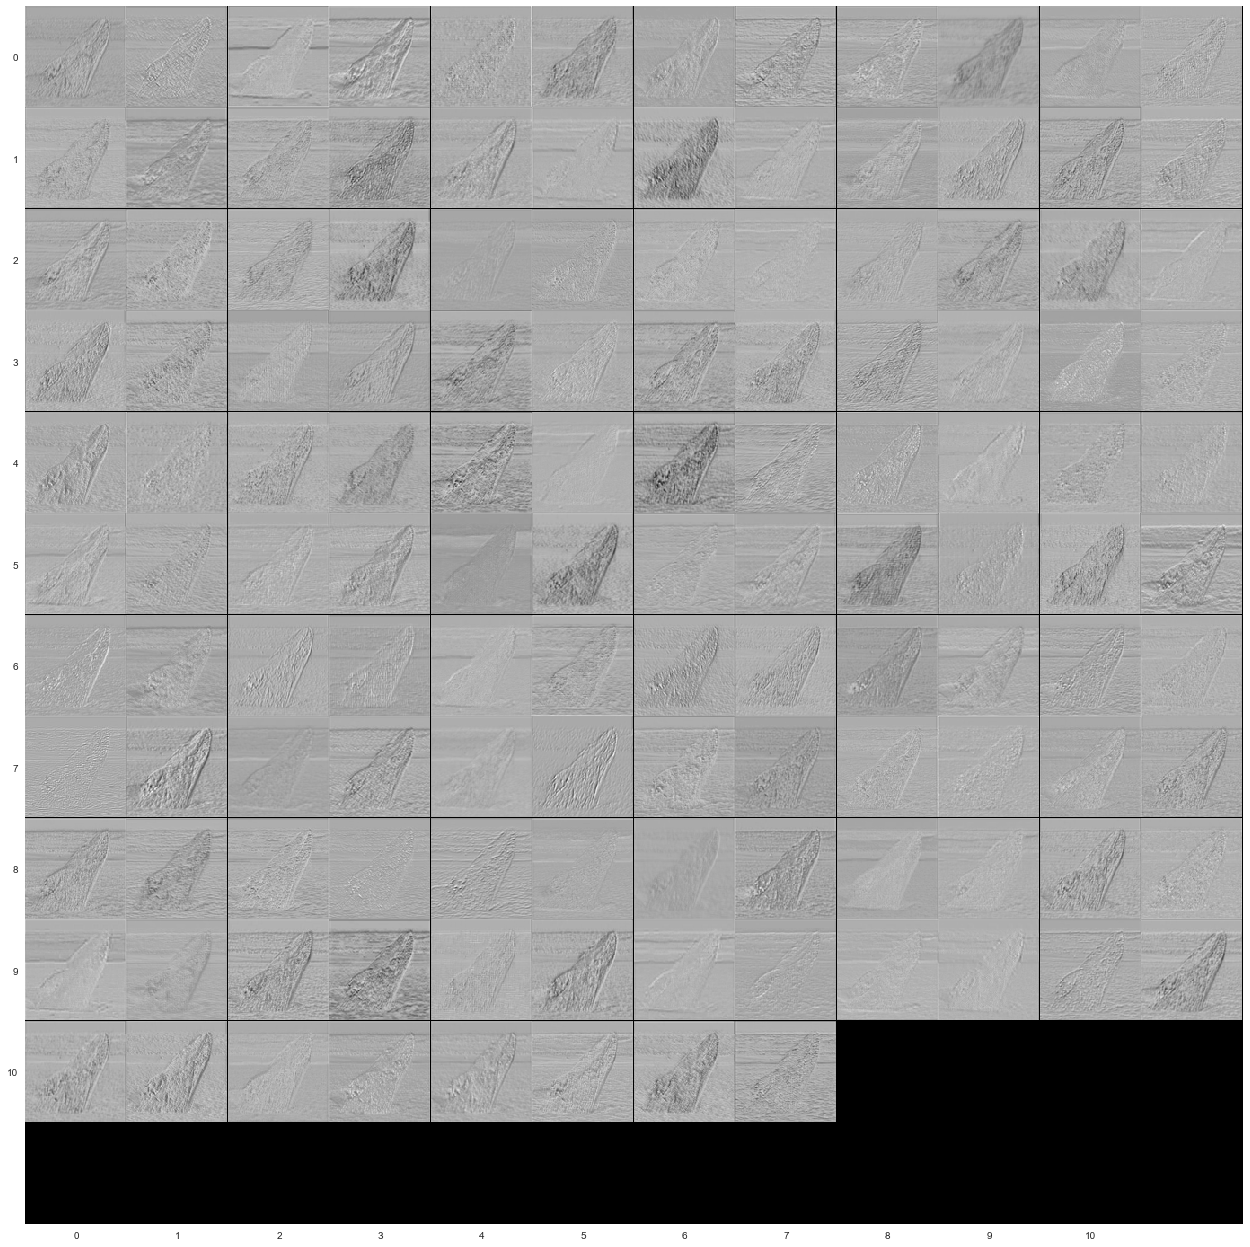

In [59]:
plt.figure(figsize=(48,48))

activ_map = vgg16_c.feature_outputs[layer].data.cpu().numpy()
activ_map_shape = activ_map.shape
k_filt = activ_map_shape[1]
print(activ_map_shape)
activ_map_grid = vis_grid(activ_map, im)
vis_layer(activ_map_grid, activ_map_shape)

ix = np.unravel_index(activ_map.argsort(axis=None)[-5:], activ_map.shape)
for i in zip(*ix):
    print("{: <22} {: <4} {: <4} {}".format(str(i), 
                                            int(i[0] % np.sqrt(k_filt)),
                                            int(i[0] / np.sqrt(k_filt)), 
                                            activ_map[i]))

In [62]:
activ_map = activ_map.transpose(1,2,3,0)

In [60]:
m = 6*12+0

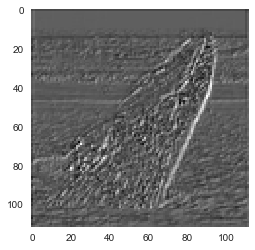

In [74]:
G=activ_map[m,:,:,im]
maxg = G.max()
ming = G.min()
G = (G - ming)/(maxg-ming)
plt.grid(False)
plt.imshow(G, cmap='gray')

In [64]:
vgg16_d = VGG16_deconv().cuda()

In [65]:
vgg16_c.feature_outputs[layer].size()

torch.Size([4, 128, 112, 112])

Maps in layer 5: 128
Map 72:
torch.Size([1, 3, 224, 224])


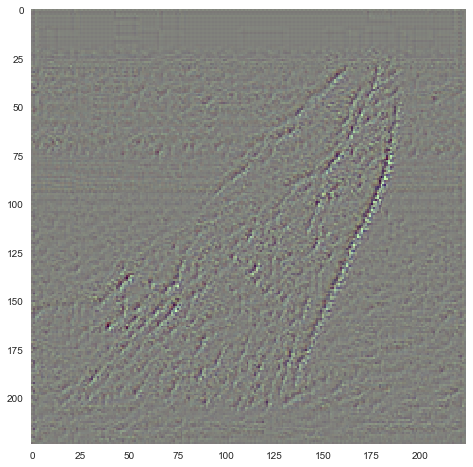

In [75]:
n_maps = activ_map.shape[0]
print("Maps in layer {}:".format(layer), n_maps)


_, map_x_dim, map_y_dim, _ = activ_map.shape
map_img_x_dim, map_img_y_dim, _ = activ_map_grid.shape
x_step = map_img_x_dim//(map_x_dim+1)


layer = 5
x_index = 6
y_index = 0
map_idx = int(x_step*x_index + y_index)

#map_idx = 2*23+16

print("Map {}:".format(map_idx))

if map_idx >= n_maps:
    print('Invalid map selected')

pool_ind_single = {k:v[[im],...] for k, v in vgg16_c.pool_indices.items()}


decon = vgg16_d(vgg16_c.feature_outputs[layer][im][map_idx][None,None,:,:], 
                layer, 
                map_idx, 
                pool_ind_single)
print(decon.size())
plt.figure(figsize=(8,8))
img = decon_img(decon)
plt.grid(False)
plt.imshow(img)


In [76]:
num_filt = vgg16_c.feature_outputs[layer].data.shape[1]
decon_maps = []

In [43]:
for i in range(num_filt):
    decon = vgg16_d(vgg16_c.feature_outputs[layer][:, i].unsqueeze(1), layer, i, vgg16_c.pool_indices).data
    decon -= decon.mean()
    decon /= decon.std()
    #decon = decon.cpu().numpy()
    decon_maps.append(decon)

In [44]:
dist = np.zeros((num_filt, num_filt), dtype=np.float32)
#num_els = float(np.prod(decon_maps.shape))

#for img in range(batchsize):
for i in range(num_filt):
    for j in range(i):
        dist[i, j] = torch.mean((decon_maps[i][:]-decon_maps[j][:])**2)#/num_els

In [45]:
with open("reconstructions.npy", 'wb') as f:
    np.save(f, dist)

In [46]:
with open("reconstructions.npy", 'rb') as f:
    dist = np.load(f)

In [47]:
for i in range(num_filt):
    for j in range(num_filt-i):
        dist[i, i+j] = np.inf

In [48]:
def get_sorts(dist):
    sorts = OrderedDict()
    for i, ind in enumerate(dist.argsort(axis=None)):
        indices = np.unravel_index(ind, dist.shape)
        indices = tuple(sorted(indices, reverse=True))
        if not indices in sorts and dist[indices] != np.inf and dist[indices] != 0:
            sorts[indices] = dist[indices]
            
    return sorts

In [49]:
top = 8
sorts = get_sorts(dist)
topsorts = OrderedDict(list(sorts.items())[:top])
topsorts

OrderedDict([((68, 15), 0.35573041),
             ((52, 40), 0.37114787),
             ((54, 15), 0.38090637),
             ((65, 27), 0.42980504),
             ((68, 18), 0.58943796),
             ((42, 33), 0.5921042),
             ((54, 40), 0.61949402),
             ((54, 33), 0.64511704)])

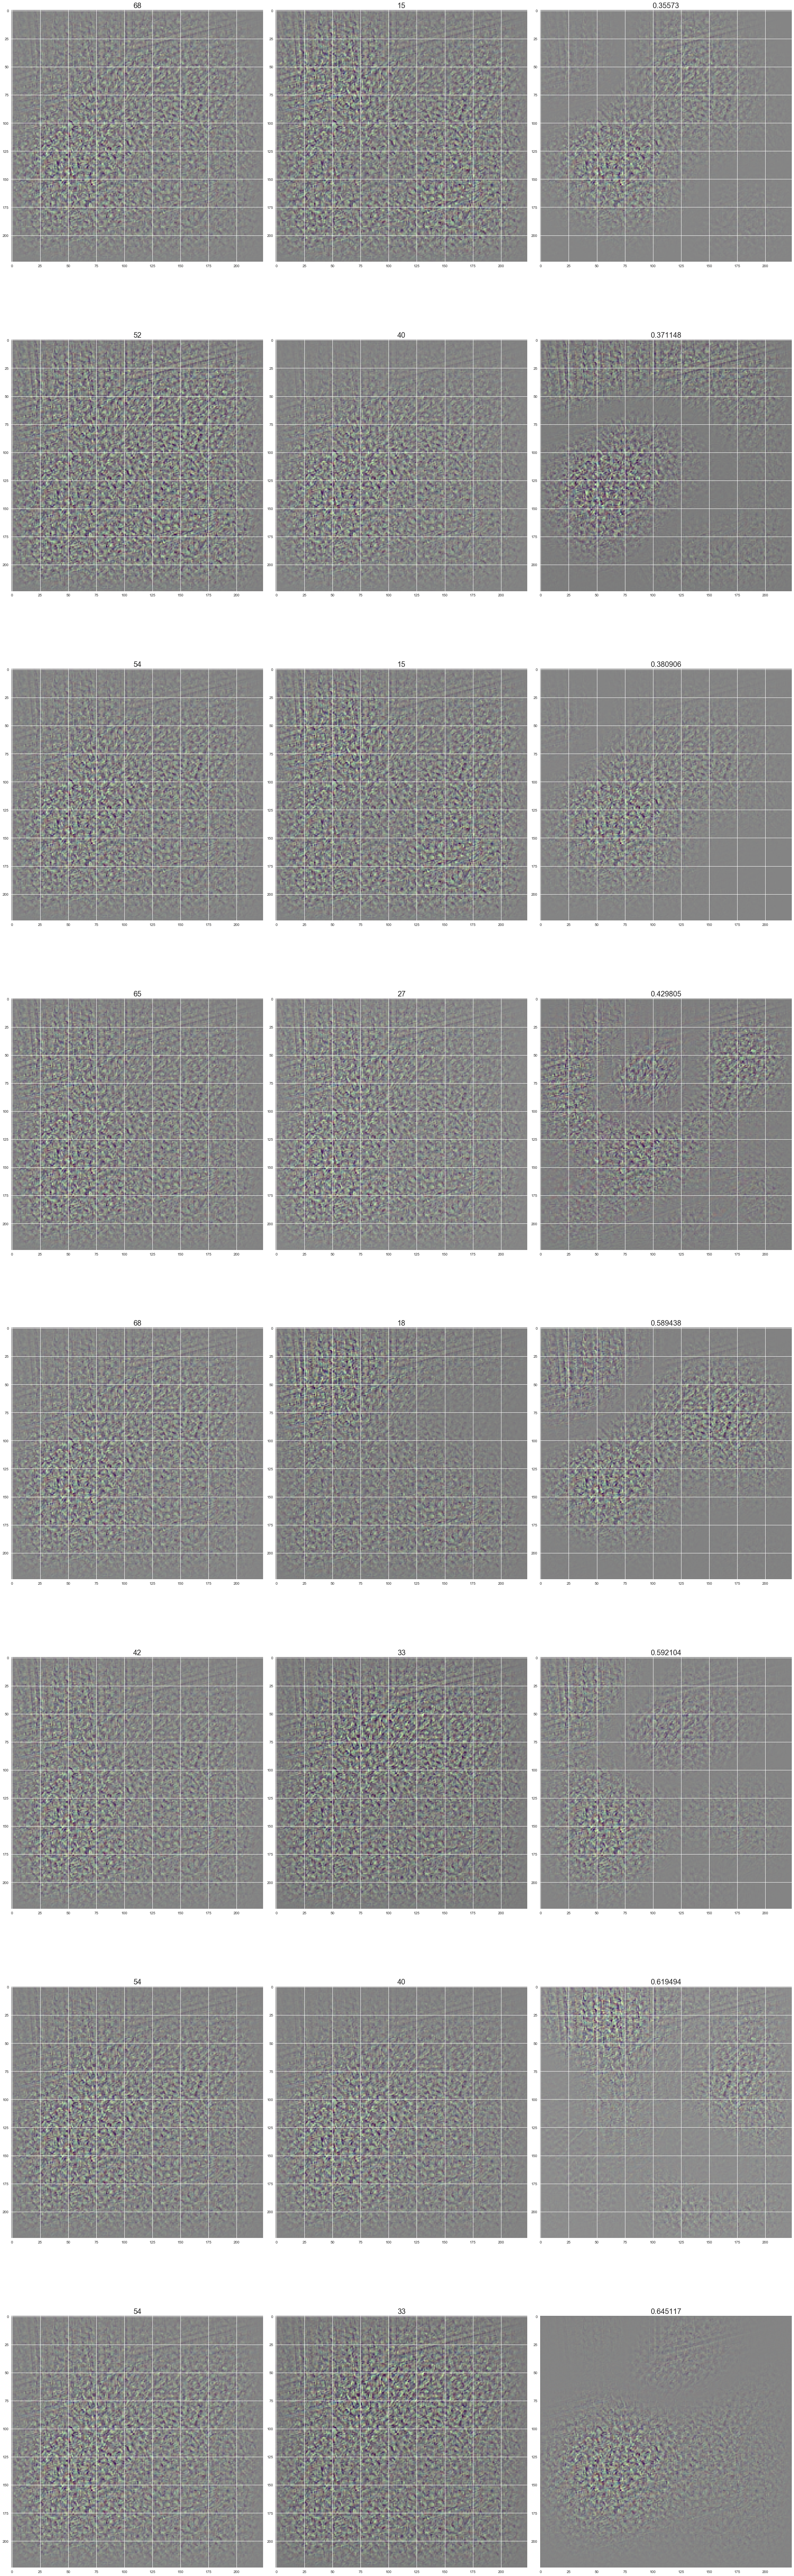

In [71]:
top = 8
f, axarr = plt.subplots(nrows=len(topsorts), ncols=3,  figsize=(30, 100))

for ind, ((i, j), diff) in enumerate(list(topsorts.items())[:top]):
    img = decon_img(decon_maps[i])
    axarr[ind, 0].set_title(str(i))
    axarr[ind, 0].title.set_fontsize(20)
    axarr[ind, 0].imshow(img)

    img = decon_img(decon_maps[j])
    axarr[ind, 1]
    axarr[ind, 1].set_title(str(j))
    axarr[ind, 1].title.set_fontsize(20)
    axarr[ind, 1].imshow(img)
    
    img = decon_img(decon_maps[i]-decon_maps[j])
    axarr[ind, 2].set_title(str(diff))
    axarr[ind, 2].title.set_fontsize(20)
    axarr[ind, 2].imshow(img)

plt.grid(False)
plt.tight_layout()
plt.show()

In [51]:
x = list(sorts.values())

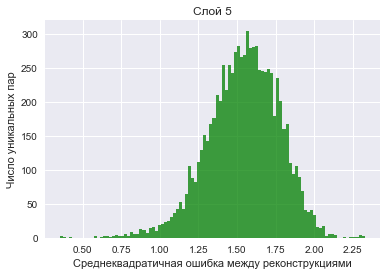

In [52]:
n, bins, patches = plt.hist(x, 100, facecolor='green', alpha=0.75)
plt.title("Слой "+str(layer))
plt.xlabel("Среднеквадратичная ошибка между реконструкциями")
plt.ylabel("Число уникальных пар")
plt.show()

In [53]:
np.mean(x), np.std(x)

(1.5413047, 0.22824515)

In [54]:
layer_list = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]

In [55]:
for layer in layer_list:
    num_filt = vgg16_c.feature_outputs[layer].data.shape[1]
    decon_maps = []
    
    for filt in range(num_filt):
        decon = vgg16_d(vgg16_c.feature_outputs[layer][:, filt].unsqueeze(1), layer, filt, vgg16_c.pool_indices).data
        decon -= decon.mean()
        decon /= decon.std()
        decon_maps.append(decon)

    dist = np.zeros((num_filt, num_filt), dtype=np.float32)
    for i in range(num_filt):
        for j in range(i):
            dist[i, j] = torch.mean((decon_maps[i][:]-decon_maps[j][:])**2)
            
    with open("reconstructions_" + str(layer) + ".npy", 'wb') as f:
        np.save(f, dist)

In [56]:
cols = 4
rows = len(layer_list)//cols + len(layer_list)%cols

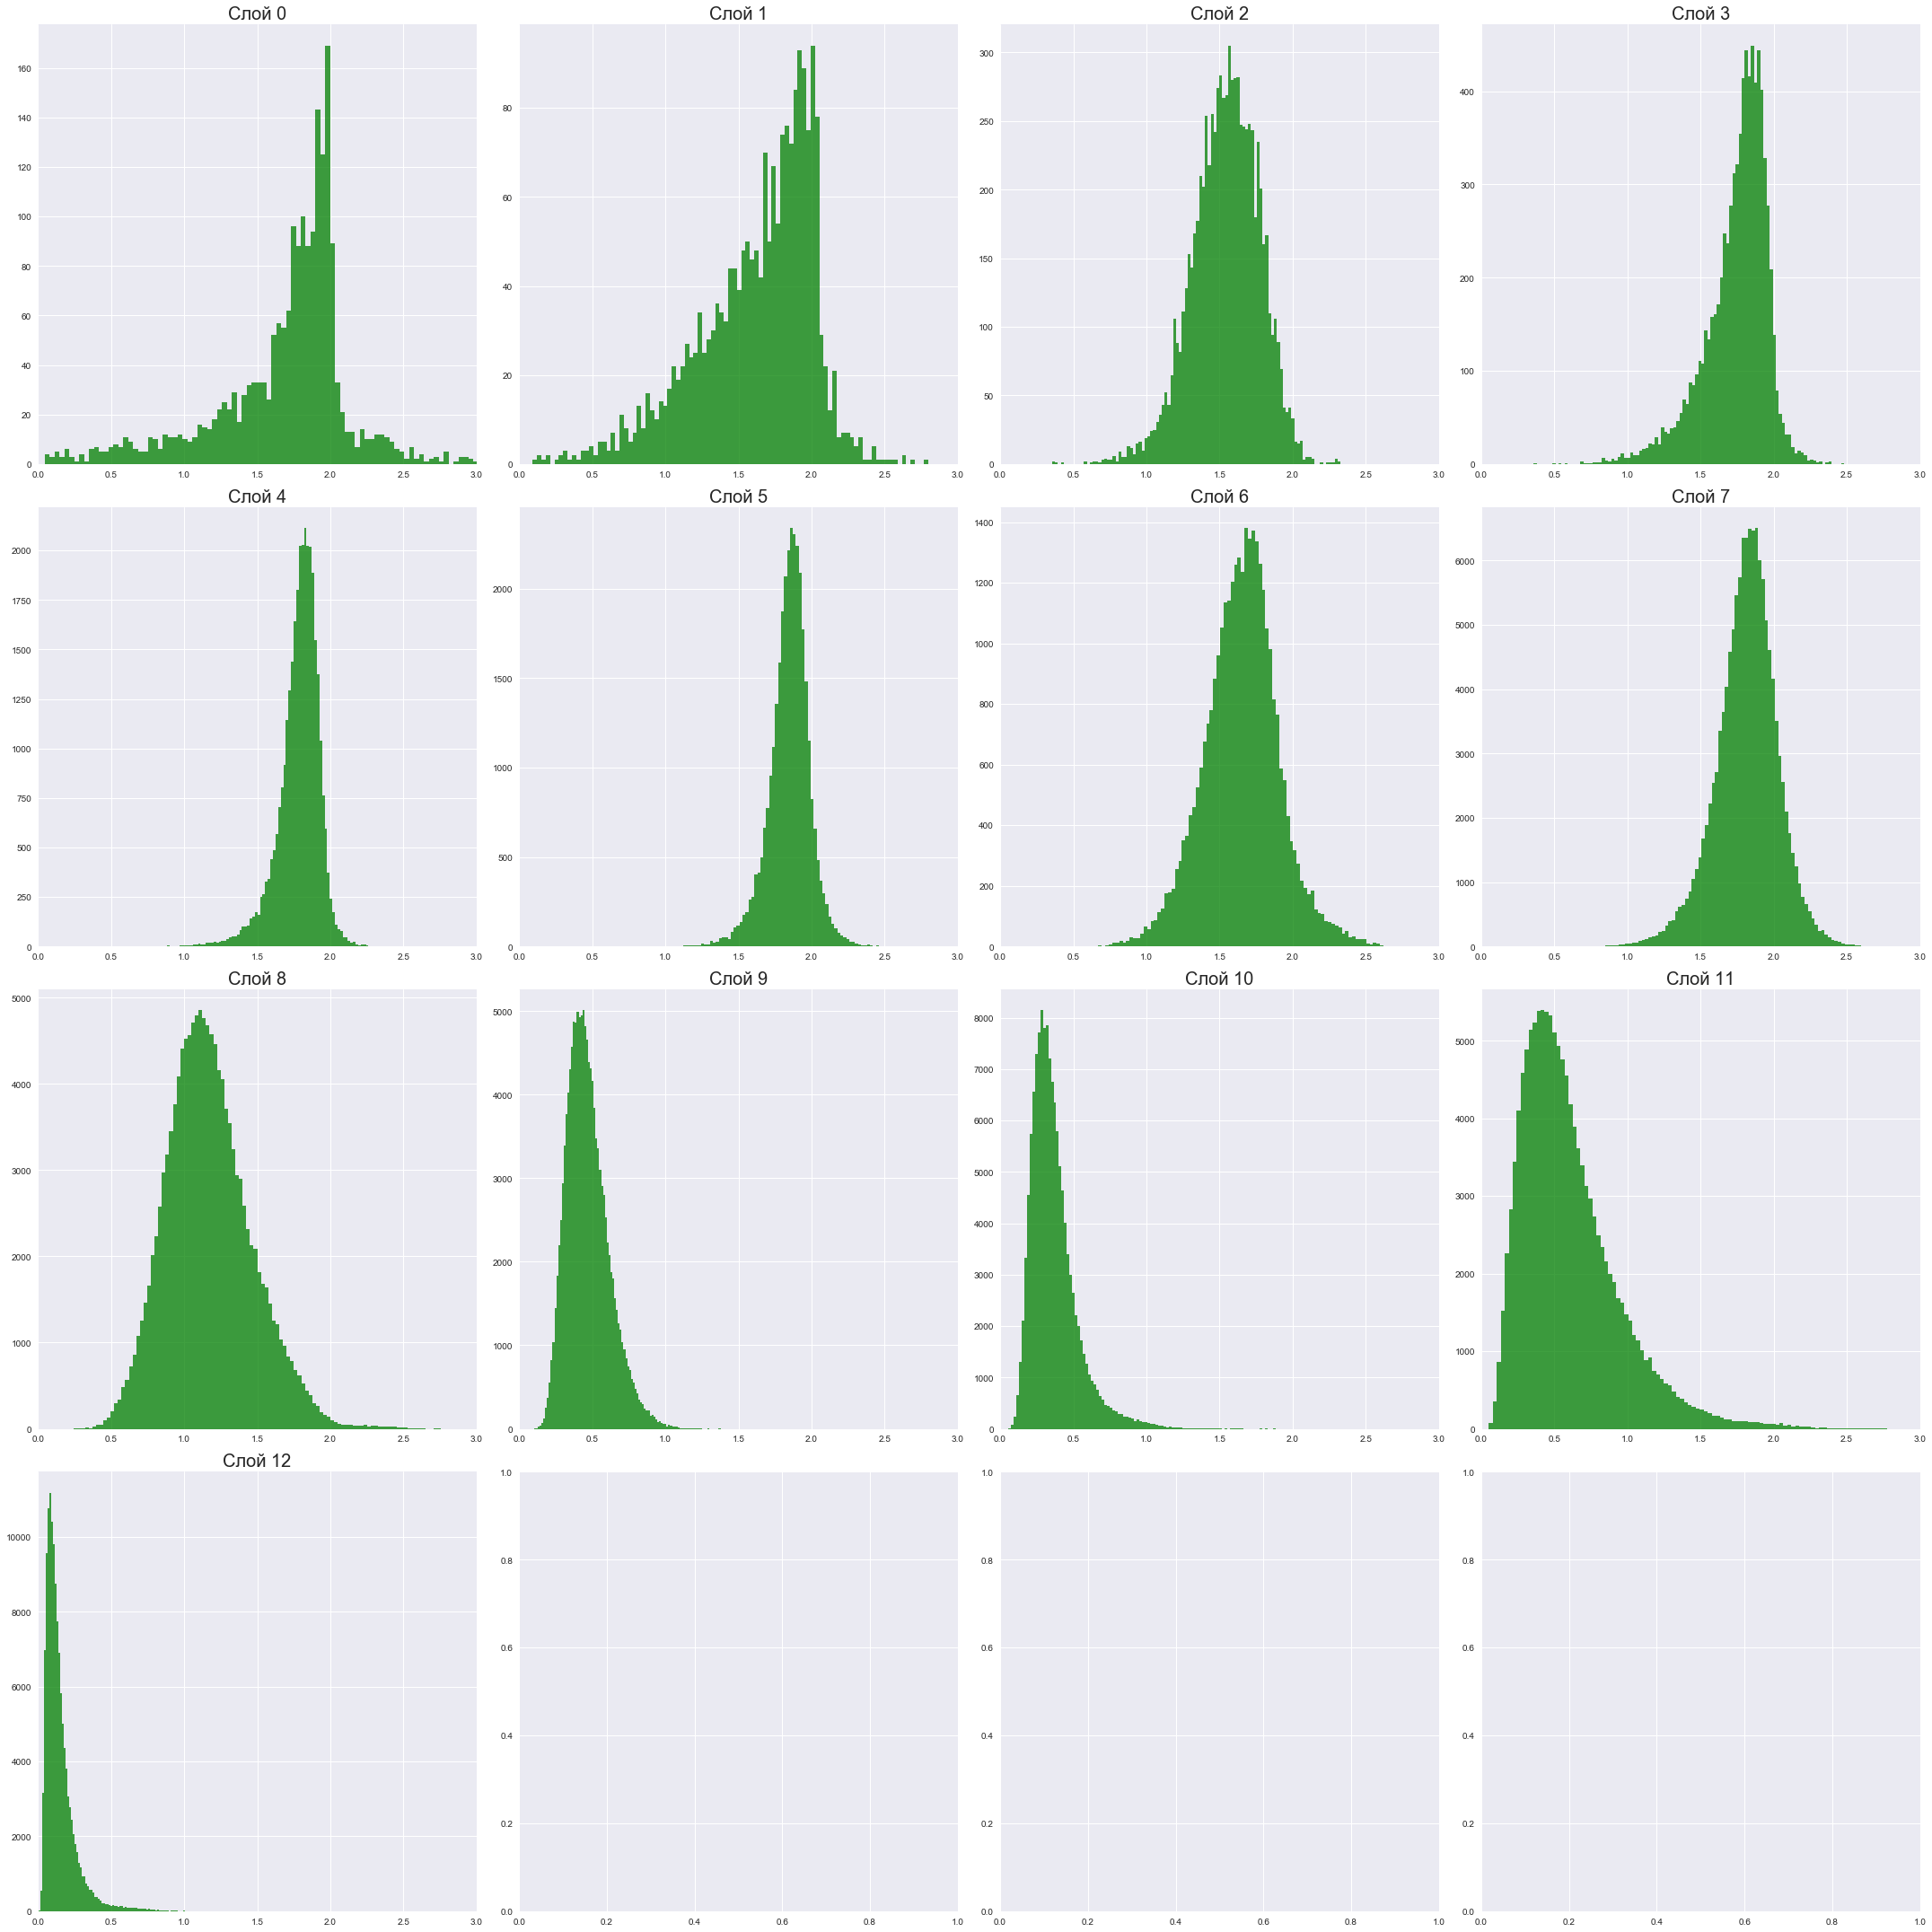

In [57]:
f, axarr = plt.subplots(nrows=rows, ncols=cols,  figsize=(30, 30))

all_sorts = []

i = 0
for row in range(rows):
    for col in range(cols):
        
        dist = None
        with open("reconstructions_" + str(layer_list[i]) + ".npy", 'rb') as f:
            dist = np.load(f)
        sorts = get_sorts(dist)
        x = list(sorts.values())
        all_sorts.append(x)
        
        axarr[row, col].set_title("Слой "+str(i))
        axarr[row, col].title.set_fontsize(20)
        axarr[row, col].hist(x, 100, facecolor='green', alpha=0.75)
        axarr[row, col].set_xlim(0, 3)
        
        i += 1
        
        if i >= len(layer_list):
            break
        
plt.tight_layout()
plt.show()

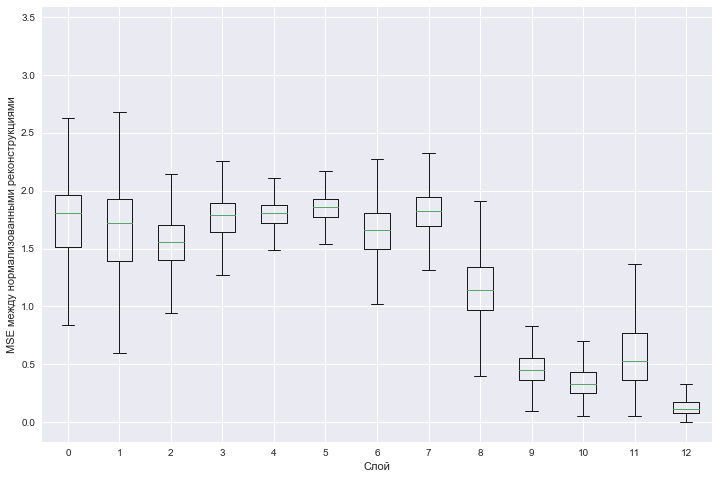

In [58]:
plt.figure(figsize=(12, 8))
plt.boxplot(all_sorts, labels=range(len(layer_list)))
plt.xlabel("Слой")
plt.ylabel("MSE между нормализованными реконструкциями")
plt.show()